# Periodic and spiking dynamics

In this notebook, we are going to train an echo states network in order to make it capable of learning a periodic dynamics ([Section 1](#Periodic)) and a multiple attractor dynamics ([Section 2](#MultipleAttractor)). In the former, the network has to be able of cyclically generating the periodic sequence. On the other hand, in [Section 2](#MultipleAttractor), we aim the network to be capable of following a dynamics that jumps over different attractors.

In the two cases of study, we are going to perform several experiments modifying the different parameters of the network in order to see the role they play. Moreover, different strategies for training the network are implemented.

The notebook is structured as follows:
+ [$\text{1. Learning a discrete periodic dynamics}$](#Periodic)
    + [$\text{1.1 Usual updating of the reservoir}$](#UsualUpdating)
    + [$\text{1.2 Preventing the network from degenerating}$](#PreventDegen)
    + [$\text{1.3 Changing the values of $W^\text{back}$}$](#ModifWback)
    + [$\text{1.4 Changing reservoir's homogeneity}$](#ModifHomogeneity)
    + [$\text{1.5 Changing the spectral radius}$](#ModifSpect)
+ [$\text{2. Multiple attractor learning}$](#MultipleAttractor)
    + [$\text{2.1 Ordered spiking}$](#OrderedSpiking)
        + [$\text{2.1.1 Testing on a sequence similar to the one used for training}$](#TestingSimilar)
        + [$\text{2.1.2 Testing on a sequence consisting of random spikes}$](#TestingDifferent)
    + [$\text{2.2 Unordered and random spiking}$](#UnorderedSpiking)
    
    
**Note:** the notebook follows the notation introduced in the "Terminology and key ideas" section from notebook "Intuition_EchoStates.ipynb".

# 1. Learning a discret periodic dynamics <a name="Periodic" ></a>

In this section, we are going to train an echo states network in order to make it learn a periodic dynamics. The main goal is that, given a particular periodic sequence, the network is able to autonomously predict the next time steps. The sequence we are going to be dealing with consists on a periodic repetition of the melody "House of the Rising Sun", which consists of 48 notes. Therefore, the signal has period 48. The notes of this melody are assigned numerical values ranging from -1 (g#) to 14 (a’), with halftone intervals corresponding to unit increments. Finally, in order to get the network's output in the range of [-1,1], the sequence is divided over 28.

The reservoir will have 400 nodes whose weights are 0, 0.4 and -0.4 with probabilities of 0.9875, 0.00625 and 0.00625 respectively. When doing the training, we will let the reservoir evolve for 1500 time steps using teacher forcing and, afterwards, we will dismiss a transient of 500 steps. 

As we are going to see, by no means, we are capable of infinitely produce accurate outputs since, at some point, the predictions degenerate. We will also see that the introduction of noise during training ([Section 1.2](#PreventDegen)) draws out the degeneration with respect to when no noise is introduced ([Section 1.1](#UsualUpdating)). In addition, we will study the behavior of the prediction for different choices of feedback connection ([Section 1.3](#ModifWback)), for different homogeneities of the reservoir ([Section 1.4](#ModifHomogeneity)) and for different values of the spectral radius of the adjacency matrix ([Section 1.5](#ModifSpect)).

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import scipy.linalg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None, W_back = None,
                 non_null_matrices = None, u = None): 
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        self.W_back = W_back #feedback connections (matrix of size self.N x self.L) (may be None)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
        
        self.u = u #input (matrix of size self.K x 1) (may be None) 
        
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))

        
    
    def orbit(self, t, squash=False):
        """
        Args:
            -t, number of time steps
            -squash, whether we want to squash the orbits into [-1,1]
        
        Returns:
            -Matrix of size 1xt given the orbit described by periodically repeating the melody "House of the
            rising sun" during t time steps. 
            The orbit is squashed into [-1,1] if squash=True.
        """
        
        House_Raising_Sun = np.array([0,0,0,2,3,3,7,5,5,0,3,3,14,14,14,14,12,7,3,7,7,7,7,7,14,14,14,14,12,12,7,5,5,0,
                             3,3,0,0,0,0,-1,-1,-1,0,0,0,0,0])
        orbit = np.concatenate((np.tile(House_Raising_Sun,int(t/48)), House_Raising_Sun[:t%48]))
        
        if squash == True:
            orbit = 1/28*orbit
                        
        return orbit.reshape((1,t))
        
        
    
    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:] 
        
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, boundary_noise=None, t_dismiss=None, t_autonom=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
            -It admits noise, in which case the boundary_noise has to be specified
        
        If test=True
            -Computes the predictions for the desired t_autonom regarding a teacher forcing of t_dismiss time steps
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            x_prev = self.trajectories[t_dismiss-1,:]
                       
                
        if test == False:             
            if noise == True:
                nu = np.random.uniform(low=-boundary_noise, high=boundary_noise, size=(self.L, self.T))
            elif noise == False:
                nu = np.zeros([self.L, self.T])                
        
        if "W_in" not in self.non_null_matrices:
            self.W_in = np.zeros([self.N, 1])
            if test == False:
                self.u = np.zeros([1, 1])            
            
        if "W_back" not in self.non_null_matrices:
            self.W_back = np.zeros([self.N, 1])
            if test == False:
                y = np.zeros([1, self.T]) 
            elif test == True:
                y = np.zeros([1, self.T+t_autonom])
                
            
        if "W_back" in self.non_null_matrices:
            if test == False:
                y = np.copy(self.y_teach)
            elif test == True:
                y = self.y_teach_test[:,t_dismiss-1].reshape(-1,1)        
   
        
        
        if test == False:
            for n in np.arange(self.T-1):
                x = np.tanh(np.dot(self.W_in,self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]+nu[:,n]))
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:
            for n in np.arange(t_autonom):
                x = np.tanh(np.dot(self.W_in, self.u[:,0])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]))
                x_prev = x
                y_next = np.tanh(self.regressor.predict(x.reshape(1,-1)))
                y_next = y_next.reshape(-1,1)
                y = np.hstack([y,y_next])                    
            return y

    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        """
        Args:
            -sel_nodes, list specifying the nodes of the reservoir to be plotted. If sel_nodes=False, it randomly
            selects num_nodes nodes of the reservoir.
        
        Returns:
            -Plots the trajectories of the given nodes.
        """
        
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()
            
            
    def train_network(self, plot=False, noise=False, boundary_noise=0.001):
        """
        Args:
            -plot, whether we want to plot the trajectories of 10 randomly selected nodes of the reservoir
            -noise, whether we want to add noise when training
            -boundary noise, if noise=True and boundary_noise=a, then the noise is going to be uniformly 
            distributed on the interval [-a,a]
        
        Returns:
            -Performs the training and returns the object self. It computes self.trajectories, self.regressor and
            prints the training MSE component-wise.
        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        #Define the ground truth
        self.initial_state = np.ones(self.N)
        self.y_teach = self.orbit(self.T, squash=True)  
        
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, boundary_noise=boundary_noise)

        #plot some trajectories
        if plot == True:
            self.plot_nodes_trajectories()
            
        regressor = LinearRegression()
        regressor.fit(self.dismiss_transient(self.trajectories), np.arctanh(self.dismiss_transient(self.y_teach.T)))
        
        #Compute MSE
        MSE_vector = 1/(self.T-self.n_min)*sum((np.arctanh(self.dismiss_transient(self.y_teach.T)) - regressor.predict(self.dismiss_transient(self.trajectories)))**2)
                
        if self.L == 1: #in case the output is one dimensional
            print("The training MSE is {}".format(MSE_vector[0])) 
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The training MSE for the {}-th dimension is {}".format(i+1, MSE_vector[i]))        
                                              
        self.regressor = regressor   
        
        return self   
    
    
    
    def test_network(self, t_dismiss, t_autonom, plot=False):
        """
        Args:
            -t_dismiss, list giving the time we let the reservoir evolve by teacher forcing.
            -t_autonom, list giving the time we let the network freely run
            -plot, whether the testing plots are going to be plotted
        
        Returns:
            -The MSE during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """  
        
        MSE = []
        for i in np.arange(len(t_dismiss)):
            #Define y_teach_test
            self.y_teach_test = self.orbit(t_dismiss[i]+t_autonom[i], squash=True)
            
                      
            #predict
            y = self.compute_nodes_trajectories(test=True, t_dismiss=t_dismiss[i], t_autonom=t_autonom[i])
        
            if plot == True:
                plt.plot(self.y_teach_test[0,t_dismiss[i]:t_dismiss[i]+t_autonom[i]], label="Desired output (y_teach)")
                plt.plot(y[0,:], '--',linewidth=1.0, label="Output of the network during the autonomous time steps")
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.show()
                
            
            #MSE 
            MSE.append(1/t_autonom[i]*sum((self.y_teach_test[0,t_dismiss[i]-1:t_dismiss[i]+t_autonom[i]]-y[0,:]).T**2)) 
        
        
        ####
        #print the results
        ####
        len_bin = 40
        col_formater = "{0:len_bin}{1:len_bin}{2:len_bin}".replace("len_bin",str(len_bin)) #format of the table
        print(col_formater.format("Teacher enforcing time steps", "Autonomously running time steps", "MSE")) #titles of the columns
        print("")
        for i in np.arange(len(MSE)):
            print(col_formater.format(str(t_dismiss[i]), str(t_autonom[i]), str(MSE[i])))           



## 1.1 Usual updating of the reservoir <a name="UsualUpdating" ></a>

In this section, the training is going to be performed as usual, which is

$$
x(n+1)=\tanh(W^\text{in}u(n+1)+Wx(n)+W^\text{back}y(n)) = \tanh(Wx(n)+W^\text{back}y(n)),
$$

since there is not input.

Let us begin by showing a period of the sequence we will be working with. That is, the melody "House of the Raising Sun".

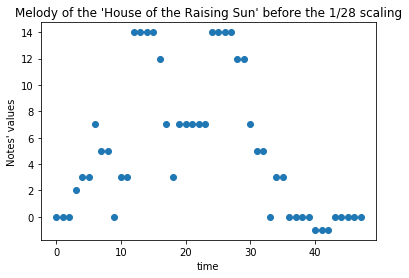

In [3]:
House_Raising_Sun = np.array([0,0,0,2,3,3,7,5,5,0,3,3,14,14,14,14,12,7,3,7,7,7,7,7,14,14,14,14,12,12,7,5,5,0,
                             3,3,0,0,0,0,-1,-1,-1,0,0,0,0,0])

plt.plot(House_Raising_Sun, 'o')
plt.xlabel("time")
plt.ylabel("Notes' values")
plt.title("Melody of the 'House of the Raising Sun' before the 1/28 scaling")
plt.show()

<ins>**DEFINITION OF THE PARAMETERS OF THE NETWORK**</ins>

In [4]:
########################
# Initialize instance
########################
Network = Network()

In [5]:
########################
# Define the parameters
########################

Network.T = 1500
Network.n_min = 500

Network.K = 1
Network.N = 400
Network.L = 1

Network.W_back = np.random.uniform(low=-2, high=2, size=Network.N*Network.L).reshape((Network.N,Network.L))
Network.non_null_matrices = ["W_back"]

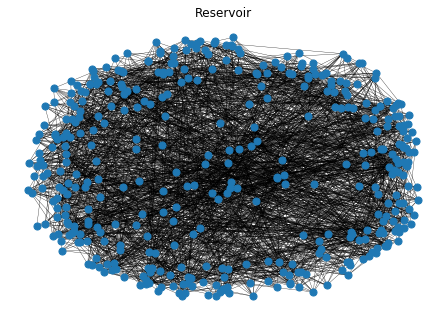

The reservoir has 400 nodes and 1947 edges


In [6]:
########################
# Reservoir
########################

Network.W = np.zeros([Network.N,Network.N]) #adjacency matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p < 0.00625:
            Network.W[i,j] = 0.4
                        
        elif 0.00625 <= p < 2*0.00625:
            Network.W[i,j] = -0.4
            
G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

Let us now compute the $|\lambda_\text{max}|$ and $|\sigma_\text{max}|$ of $W$.

In [7]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 0.925734795154925
The maximum singular value (in module) is 1.9645268028645781


<ins>**TRAINING**</ins>

Let us now perform the training. Notice that, in this case, there is no input but feedback. Therefore, the training is going to be performed by means of teacher forcing, which is as follows

$$
x(n+1)=f(W^\text{in}u(n+1)+Wx(n)+W^\text{back}y^\text{teach}(n))=\tanh(Wx(n)+W^\text{back}y^\text{teach}(n)).
$$

We will now compute the trajectories of the nodes of the reservoir for 1500 time steps. Afterwards, we will dismiss a transient of 500 time steps.

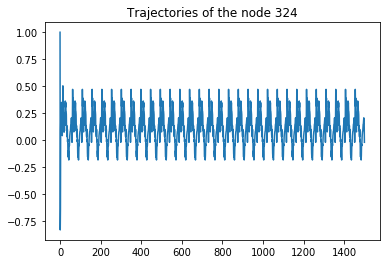

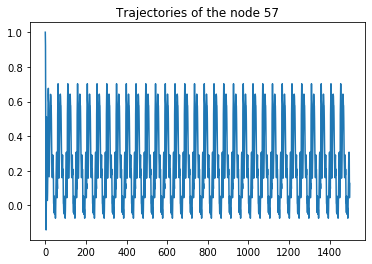

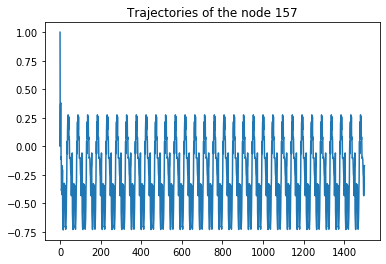

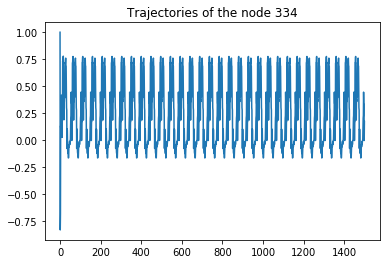

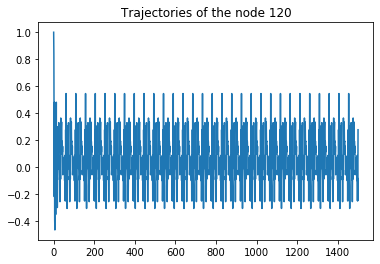

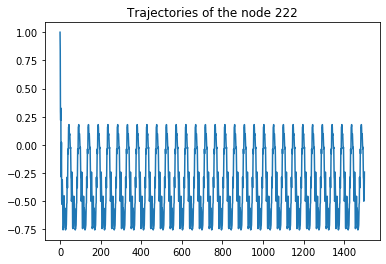

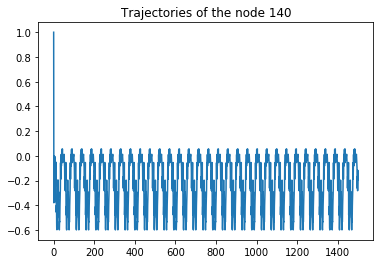

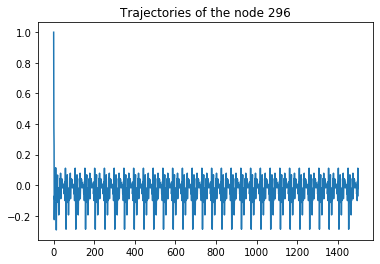

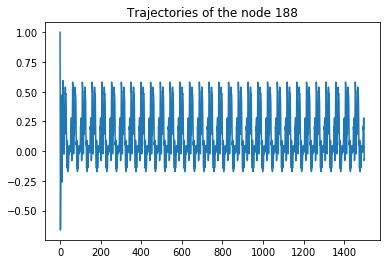

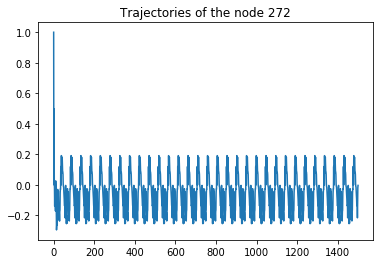

The training MSE is 1.8971631348096055e-28


In [8]:
#At the end of the plots, the training MSE is printed
Network.train_network(plot=True)

Notice that the training error is of 1.90e-28 (although this value may slightly vary depending on the execution).

<ins>**TESTING**</ins>

Let us now perform some testing. Now, the updating of the reservoir is done as follows

$$
x(n+1)=f(W^\text{in}u(n+1)+Wx(n)+W^\text{back}y(n))=\tanh(Wx(n)+W^\text{back}y(n)),
$$

where $y(n)$ is the output of the network at time *n*. Recall that the output is given by

$$
y(n+1)=\tanh(W^\text{out}x(n+1)).
$$

We will begin by letting the reservoir evolve using teacher forcing for 500 steps. After doing so, the dynamics of the reservoir will have converged to the periodic trajectories. Then, we will let the network autonomously run for 300 more time steps.

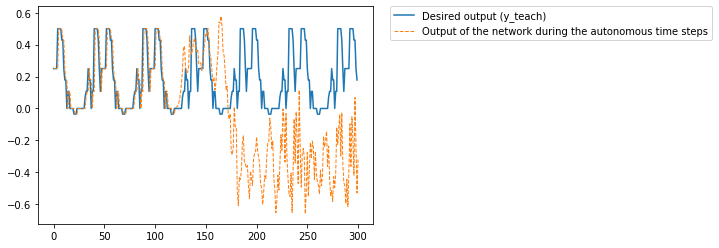

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     0.1556381413032053                      


In [9]:
Network.test_network(t_dismiss=[500], t_autonom=[300], plot=True)

By looking at the above picture, we can see that, once the network has autonomously run for almost 125 time steps, it begins to degenerate. In other words, the periodic orbits at which the network converge are unstable. The reason for such behaviour is because the equation we minimize when training, which is

$$
\text{MSE}_\text{train} = \frac{1}{1000}\sum_{n=501}^{1500}\left(\tanh^{-1}y_\text{teach}(n)-W^\text{out}x(n)\right)^2, 
$$

is equivalent to

$$
\text{MSE}_\text{train} = \frac{1}{48}\sum_{n=501}^{548}\left(\tanh^{-1}y_\text{teach}(n)-W^\text{out}x(n)\right)^2
$$

since $y_\text{teach}$ and $x(n)$ are 48-periodic. Therefore, in order to determine the 400 values that compose $W^\text{out}$, we only dispose of 48 linearly independent arguments. Thus there are many possible values of $W^\text{out}$ that would minimize the above equation. Then, when doing the ``.fit``, one of them is arbitrarily chosen.

## 1.2 Preventing the network from degenerating <a name="PreventDegen" ></a>

As we previously stated, the degeneration of the network's behaviour is due to the fact that the periodicity of $y^\text{teach}$ and $x(n)$ render the computation of $W^\text{out}$ underdetermined when performing the MSE. One way of avoiding such underdetermination is by introducing some noise when updating the state of the reservoir. By doing so, we will prevent $x(n)$ from being periodic. 

Therefore, the updating is going to be carried out as follows

$$
x_\text{wobble}(n+1)=\tanh\left[Wx_\text{wobble}(n)+W^\text{back}(y^\text{teach}(n)+\nu(n))\right],
$$

where the noise $\nu(n)$ is uniformly sampled from [−0.001, 0.001]. Notice that we now use the notation $x_\text{wobble(n)}$ to denote the state of the reservoir at time $n$. This slight change of notation is to make it clear that we are introducing some noise. Now, the equation we want to minimize, which is

$$
\text{MSE}_\text{train} = \frac{1}{1000}\sum_{n=501}^{1500}\left(\tanh^{-1}y^\text{teach}(n)-W^\text{out}x_\text{wobble}(n)\right)^2,
$$

is composed of 1000 linearly independent arguments since we actually have 1000 values of $x_\text{wobble}$.

<ins>**TRAINING**</ins>

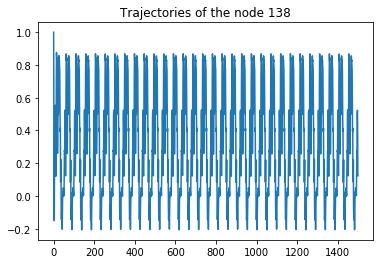

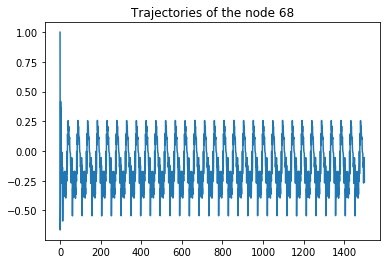

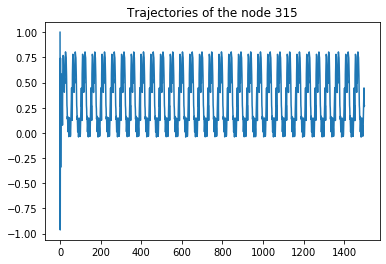

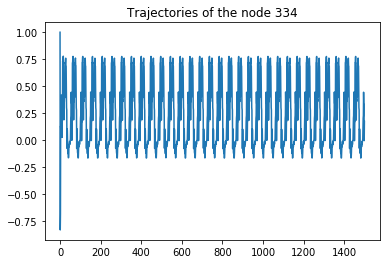

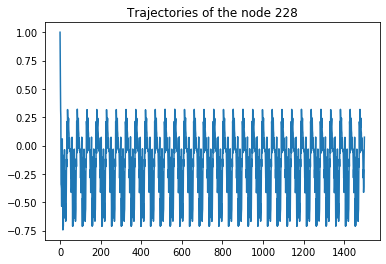

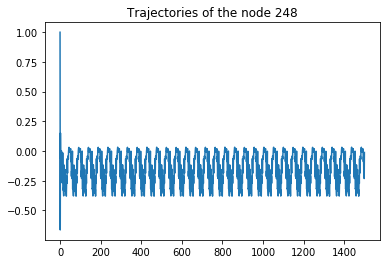

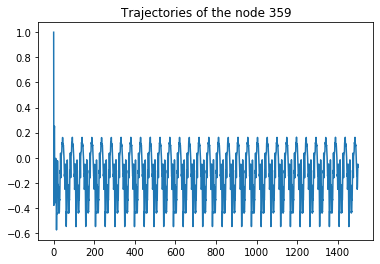

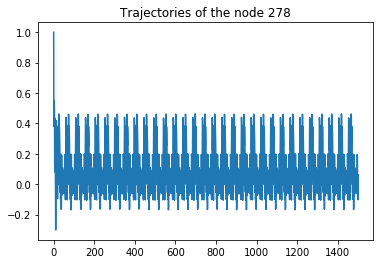

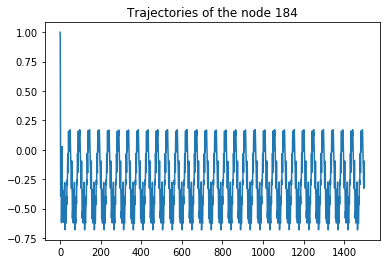

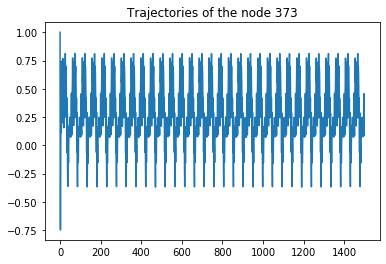

The training MSE is 6.862968796644391e-08


In [11]:
#The training MSE is printed after the plots
Network.train_network(noise=True, boundary_noise=0.001, plot=True)

Notice that the training MSE is of 6.86e-8, which is higher than the one obatined in the above case (1.90e-28).

<ins>**TESTING**</ins>

When doing the testing, the update of the reservoir is performed as usual, that is, without noise. In other words,

$$
x(n+1)=\tanh(Wx(n)+W^\text{back}y(n)).
$$

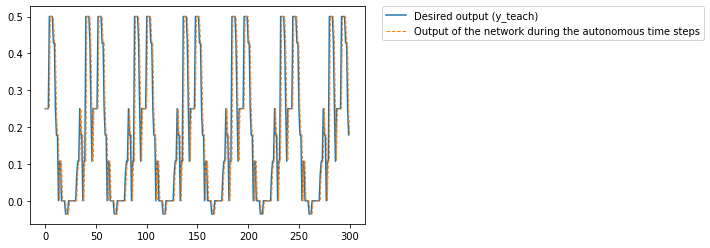

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     8.81671413048832e-08                    


In [13]:
Network.test_network(t_dismiss=[500], t_autonom=[300], plot=True)

Therefore, as opposed to the previous case, it does not degenerate after freely running for 300 time steps. Let us now see what happens if we vary the number of training and testing time steps.

In [14]:
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     8.81671413048832e-08                    
500                                     10000                                   9.094286787493562e-08                   
30                                      10000                                   1.0096834183444049e-07                  


Notice that after performing only 30 time steps of teacher forcing, then the network is capable of autonomously run for another 10000 time steps achiving a MSE of 1.00e-7, which is a very accurate result.

## 1.3 Changing the values of $W^\text{back}$ <a name="ModifWback" ></a>

Let us now try the same approach but changing the values of the connections $W^\text{back}$. Recall that, so far, we have regarded $W^\text{back}$ to be randomly generated by uniformly taking values on [-2,2]. The values of $W^\text{back}$ we are going to use are uniformly sampled from: [[-0.5,0.5]](#Unif_05), [[-0.01,0.01]](#Unif_001), [[-4,4]](#Unif_4), [[-6,6]](#Unif_6), [{-1,1}](#Unif_1) and [{-3,3}](#Unif_3).

Since we have just seen that introducing some noise when training, results in a more robust network, we are going to perform the training with noise.

Let us begin by using the same $W^\text{back}$ as above. It will provide us a benchmark against which to compare the results.

In [15]:
Network.W_back = np.random.uniform(low=-2, high=2, size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 9.012996179104047e-08
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     5.113371840401599e-07                   
500                                     10000                                   6.539762529144322e-06                   
30                                      10000                                   6.604550597059049e-06                   


**$W^\text{back}$ uniformly sampled from [-0.5,0.5]** <a name="Unif_05" ></a>

In [16]:
Network.W_back = np.random.uniform(low=-0.5, high=0.5, size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 1.1641766234626008e-07
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     2.674171459546502e-07                   
500                                     10000                                   1.7924459122627287e-07                  
30                                      10000                                   1.0494826287773789                      


**$W^\text{back}$ uniformly sampled from [-0.01,0.01]** <a name="Unif_001" ></a>

In [17]:
Network.W_back = np.random.uniform(low=-0.01, high=0.01, size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 9.243546558817892e-08
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     7.39179736313381e-07                    
500                                     10000                                   0.9818346059973235                      
30                                      10000                                   1.0859579618315027                      


**$W^\text{back}$ uniformly sampled from [-4,4]** <a name="Unif_4" ></a>

In [18]:
Network.W_back = np.random.uniform(low=-4, high=4, size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 1.149299588926607e-07
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     7.625979665079206e-08                   
500                                     10000                                   7.782598820669718e-08                   
30                                      10000                                   7.921695751224449e-08                   


**$W^\text{back}$ uniformly sampled from [-6,6]** <a name="Unif_6" ></a>

In [21]:
Network.W_back = np.random.uniform(low=-6, high=6, size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 3.2249764285260256e-07
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     0.6401890092496778                      
500                                     10000                                   1.0378718678639167                      
30                                      10000                                   1.0383988746782873                      


**$W^\text{back}$ uniformly sampled from {-1,1}** <a name="Unif_1" ></a>

In [23]:
Network.W_back = np.random.choice(np.array([-1,1]), size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 7.266870145935517e-08
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     9.885275286696205e-08                   
500                                     10000                                   1.1332094124034724e-07                  
30                                      10000                                   1.1538877839088365e-07                  


**$W^\text{back}$ uniformly sampled from {-3,3}** <a name="Unif_3" ></a>

In [24]:
Network.W_back = np.random.choice(np.array([-3,3]), size=(Network.N,Network.L))
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 4.2668740162460756e-07
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     0.1115807590157848                      
500                                     10000                                   0.15339940391080667                     
30                                      10000                                   0.14740182947681021                     


By looking at these experiments, we see that when we let the reservoir evolve for 500 time steps using teacher forcing and, afterwards, we let it freely run for 300 time steps, the networks behaves quite robustly independently of the particular $W^\text{back}$.

In addition, we see that $W^\text{back}$ can be uniformly chosen from [-a,a] for $a\in [0.5,4]$ without much influence in the network's behaviour. Finally, it seems that, for smaller values of $a$, the network needs to undergo the teacher forcing step for longer time in order to achieve good performance.

## 1.4 Changing reservoir's homogeneity <a name="ModifHomogeneity" ></a>

We are now going to define the same $W^\text{back}$ as initially. That is, its components are uniformly chosen from [-2,2]. Then, we are going to define homogeneous reservoirs (the same as in Section 2.2.2 from notebook "Intuition_EchoStates.ipynb".) so as to see how the performance of the network changes. The cases we are going to consider are: [Fully-connected with the same weights](#FullConWeights), [fully-connected with different weights](#FullConDifWeights) and [non fully-connected with different weights](#NonFullConWeights).

The training of the network is going to be carried out as in [Section 1.2](#PreventDegen).

In [25]:
Network.W_back = np.random.uniform(low=-2, high=2, size=(Network.N,Network.L))

### Fully-connected reservoir with the same weights <a name="FullConWeights" ></a>

Let us now define an homogeneous reservoir. In particular, we are going to take a fully-connected graph were each edge has the same weight. The weights are chosen so as to get a maximum singular value lower than 1, since it guarantees the existence of echo states. 

In [26]:
Network.W = 1/401*np.ones([Network.N,Network.N]) #adjacency matrix
_,s,_ = scipy.linalg.svd(Network.W)
print("Maximum singular value: {}".format(s[0]))
print("Maximum eigenvalue (in module): {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))

Maximum singular value: 0.9975062344139645
Maximum eigenvalue (in module): 0.9975062344139656


The training MSE is 0.006205475068553343


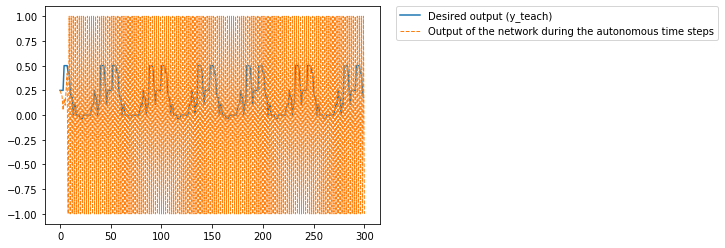

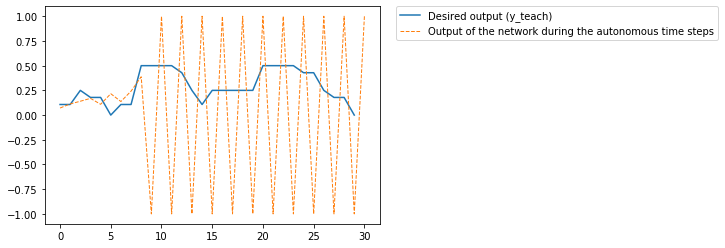

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     1.0310377508076851                      
100                                     30                                      0.8588296903460797                      


In [28]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 100], t_autonom=[300, 30], plot=True)

On the one hand, we see that the training error is 0.0062, which is not very low. On the other hand, when plotting the test step, we observe that the output signal of the network follows a constant pattern that has nothing to do with the desired output. Notice that, since the reservoir is a fully-connected graph with the same weights, the trajectories of the nodes will all be the same. Therefore, the output of the network will follow the same trajectory as the nodes but multiplied by a scalar. Thus the behaviour of the output of the network (plotted in orange in the above pictures) is as one would expect.

In conclusion, by using a reservoir of this type, one would expect to obtain a network that is not capable of learning. Its output will be proportional to the nodes' trajectories, which are all the same.

### Fully-connected reservoir with different weights <a name="FullConDifWeights" ></a>

Let us now define a fully-connected reservoir whose weights are uniformly sampled from [-1/24,1/24]. The factor of 1/24 is needed to get a maximum singular value below 1.

In [29]:
Network.W = 1/24*np.random.uniform(low=-1, high=1, size=Network.N*Network.N)#adjacency matrix
Network.W = np.resize(Network.W,(Network.N,Network.N))
_,s,_ = scipy.linalg.svd(Network.W)
print("Maximum singular value: {}".format(s[0]))
print("Maximum eigenvalue (in module): {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))

Maximum singular value: 0.9524352056214087
Maximum eigenvalue (in module): 0.494140795040952


In [22]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 300], t_autonom=[300, 1000, 10000], plot=False)

The training MSE is 1.0269053372098708e-07
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     3.061488844356067e-08                   
500                                     1000                                    3.3035810678786566e-08                  
300                                     10000                                   3.3976630083680676e-08                  


In comparison with the previous one, this network has learnt to output the desired signal. Notice that, by just considering a wide variety of reservoir' weights, the trajectories of the nodes become enough inhomogeneous so as to learn the output. In this case, we get the same result as in the original one, which was in [Section 1.2](#PreventDegen), where the reservoir was farther sparse. Therefore, we have obtained the same results but with many more computations.

### Non Fully-connected reservoir with different weights <a name="NonFullConWeights" ></a>

Let us now define a reservoir whose weights are 0 and -1/29 and 1/29 with probabilities 0.5, 0.25 and 0.25. The factor 1/29 is to get a maximum singular value below 1, which assures echo states. Notice that around 50% of the edges are missing.

In [32]:
Network.W = random.choices([-1/29,1/29], k=Network.N*Network.N) #adjacency matrix
Network.W=np.reshape(Network.W,(Network.N,Network.N))
         
for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p <0.5:
            Network.W[i,j] = 0

_,s,_ = scipy.linalg.svd(Network.W)
print("Maximum singular value: {}".format(s[0]))
print("Maximum eigenvalue (in module): {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))

Maximum singular value: 0.9680657511375783
Maximum eigenvalue (in module): 0.5042458297046698


In [34]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 1.1137285854622557e-07
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     5.031127492424133e-08                   
500                                     10000                                   6.684401135533448e-08                   
30                                      10000                                   6.82993738946651e-08                    


By looking at the MSE, it seems that this reservoir is inhomogeneous enough so as to produce the desired output for a huge number of time steps. In fact, these results were also obtained in [Section 1.2](#PreventDegen), where the weights were 0, -0.4 and 0.4 with probabilities 0.9875, 0.00625 and 0.00625. However, observe that in this latter mentioned case, the number of connections is much lower, which implies that the procedure is computationally less expensive.

**In conclusion**, if the reservoir is homogeneous, then the network is not capable of learning. Then, as it becomes inhomogeneous, the network may learn but it may degenerate after freely running for some time steps. The best way of obtaining an inhomogeneous reservoir is by regarding a sparse reservoir. That is, a reservoir with 1-2% of connectivity. By doing so, a wide variety of behaviours of the nodes are encouraged, which is key to make it capable of robustly learning the desired output. Moreover, its low percentage of connectivity entails a lower computational cost.

## 1.5 Changing the spectral radius <a name="ModifSpect" ></a>

We are going to repeat the same learning approach, but we are now going to modify the values of the adjacency matrix so as to see how the spectral radius influences the learning process. In fact, as $|\lambda_\text{max}|$ gets closer to 1, the network has more memory. Let us now recall one period of the sequence we aim to learn how to predict.

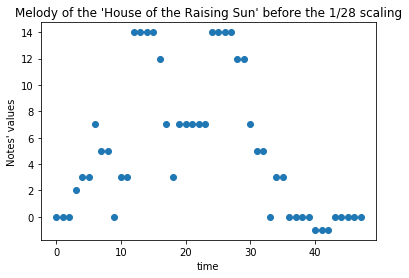

In [35]:
House_Raising_Sun = np.array([0,0,0,2,3,3,7,5,5,0,3,3,14,14,14,14,12,7,3,7,7,7,7,7,14,14,14,14,12,12,7,5,5,0,
                             3,3,0,0,0,0,-1,-1,-1,0,0,0,0,0])

plt.plot(House_Raising_Sun, 'o')
plt.xlabel("time")
plt.ylabel("Notes' values")
plt.title("Melody of the 'House of the Raising Sun' before the 1/28 scaling")
plt.show()

Notice that, at some time steps, the melody has the same note repeated many times. The moment where there are more notes repeated is at the last 5 time steps followed by the first 3. Therefore, the network has to have enough memory so as to output (and input) 8 consecutive times the same note but not get stuck to it.

In this section, the "base" reservoir is going to be constructed with weights of 0, -0.4 and 0.4 with probabilites of 0.9875, 0.00625 and 0.00625. This is actually the reservoir we have been using so far. Afterwards, the adjacency matrix is going to be rescaled so as to have the desired spectral radius. The values of $\lambda_\text{max}$ we are going to consider are: [0.9 (original value)](#SpecOrig), [0.99](#Spec_099), [0.79](#Spec_079), [0.27](#Spec_027), [0.15](#Spec_015) and [0.09](#Spec_009).

In [42]:
#adjacency matrix
Network.W = np.zeros([Network.N,Network.N]) 

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p < 0.00625:
            Network.W[i,j] = 0.4             
            
        elif 0.00625 <= p < 2*0.00625:
            Network.W[i,j] = -0.4        
    

### Original Network (base network):  $|\lambda_\text{max}|\sim 0.9$ <a name="SpecOrig" ></a>

In this approach we are going to use the base network. That is, we are going to use the same parameters as in the first case of the section 3.

In [43]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))            

The maximum eigenvalue (in module) is 0.9280747195034609
The maximum singular value (in module) is 1.9233152766501362


In [44]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 1000, 10000], plot=False)

The training MSE is 7.142918453805843e-08
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     5.2421477857999006e-08                  
500                                     1000                                    5.0927796900563496e-08                  
30                                      10000                                   5.291427232306007e-08                   


### $\boldsymbol{|\lambda_\text{max}|\sim 0.99}$ <a name="Spec_099" ></a>

We are going to increase the memory of the network. Therefore, we expect to obtain similar results.

In [47]:
alpha = 0.99/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [48]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))            

The maximum eigenvalue (in module) is 0.9899999999999951
The maximum singular value (in module) is 2.0516474416007746


In [50]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 7.524530289303306e-08
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     2.868314408297216e-08                   
500                                     10000                                   1.2173358879721538e-08                  
30                                      10000                                   1.5816224110801766e-08                  


### $\boldsymbol{|\lambda_\text{max}|\sim 0.79}$ <a name="Spec_079" ></a>

We are going to decrease the memory of the network.

In [51]:
alpha = 0.79/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [52]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))            

The maximum eigenvalue (in module) is 0.7899999999999997
The maximum singular value (in module) is 1.6371732109743626


In [53]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500, 30], t_autonom=[300, 10000, 10000], plot=False)

The training MSE is 7.07117691921727e-08
Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     1.1229716336985097e-08                  
500                                     10000                                   8.505067418245635e-09                   
30                                      10000                                   8.578438021256482e-09                   


The results are very similar to the previous ones.

### $\boldsymbol{|\lambda_\text{max}|\sim 0.27}$ <a name="Spec_027" ></a>

We are going to decrease the memory of the network even more.

In [54]:
alpha = 0.27/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [55]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0])) 

The maximum eigenvalue (in module) is 0.27000000000000135
The maximum singular value (in module) is 0.5595402113456684


The training MSE is 1.9227698195009362e-07


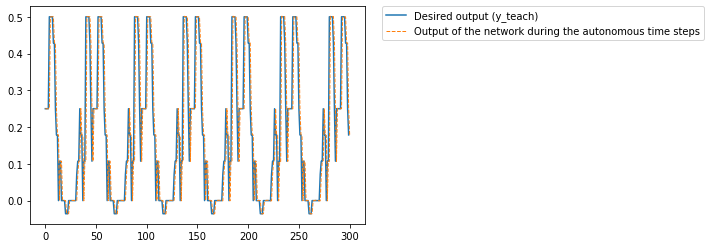

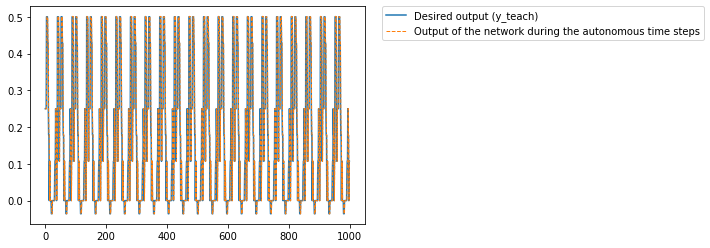

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     3.1549274141943623e-07                  
500                                     1000                                    4.116830444817573e-07                   


In [56]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500], t_autonom=[300, 1000], plot=True)

### $\boldsymbol{|\lambda_\text{max}|\sim 0.15}$ <a name="Spec_015" ></a>

In [27]:
alpha = 0.15/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [28]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0])) 

The maximum eigenvalue (in module) is 0.15
The maximum singular value (in module) is 0.31861243600841926


The training MSE is 3.054745879033267e-07


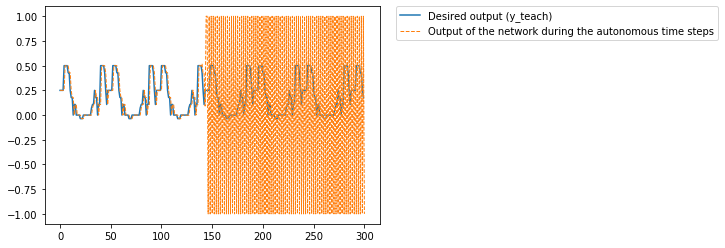

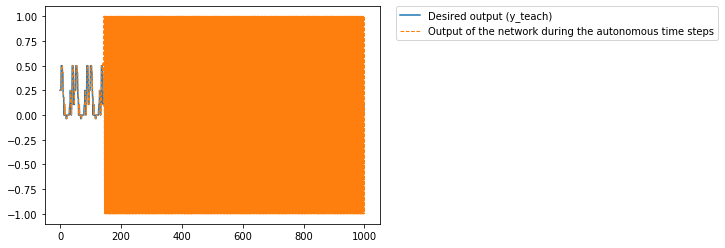

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     0.5513107357279365                      
500                                     1000                                    0.8987363329632772                      


In [29]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500, 500], t_autonom=[300, 1000], plot=True)

### $\boldsymbol{|\lambda_\text{max}|\sim 0.09}$ <a name="Spec_009" ></a>

We are going to decrease the memory of the network even more.

In [57]:
alpha = 0.09/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [58]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0])) 

The maximum eigenvalue (in module) is 0.08999999999999979
The maximum singular value (in module) is 0.18651340378188863


The training MSE is 6.017056419085396e-07


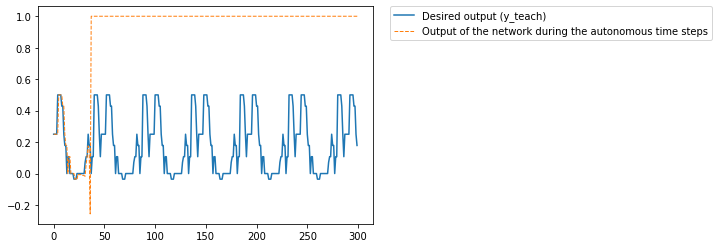

Teacher enforcing time steps            Autonomously running time steps         MSE                                     

500                                     300                                     0.6035352847875846                      


In [60]:
Network.train_network(noise=True, boundary_noise=0.001, plot=False)
Network.test_network(t_dismiss=[500], t_autonom=[300], plot=True)

As $|\lambda_\text{max}|$ decreases, so does the memory of the network. Therefore, we see that, if $|\lambda_\text{max}|=0.15$, it properly predicts around 150 time steps but then degenerates. If this value is lowered, like $|\lambda_\text{max}|=0.09$,  the network has not enough memory so as to predict the desired result.

# 2. Multiple attractor learning <a name="MultipleAttractor" ></a>

In this section, we are going to train a network so as to learn a dynamics characterized by having multiple attractors. We are going to consider a 20-dimensional spiking input. In the first experiment, the spike is going to spark once every 200 time steps and in one component at a time ([Section 2.1](#OrderedSpiking)) whether, in the second one, the spike is going to be produced with probability 0.02 at a random position ([Section 2.2](#UnorderedSpiking)).

The goal is to produce an output, which will be a 20-dimensional vector as well, to provide a description of the spikes' ordering. That is, each $i$-th component (or *channel*) of the output has two possible values: 0.5 and -0.5. The former is token whenever the $i$-th input channel was the last that spiked; the latter, otherwise. The task specifications are explained in more detail in the already mentioned sections.

In [Section 2.1](#OrderedSpiking), we test the network for two different type of input sequences: sequences of the same type as the ones used for training, which are, sequences where the spike sparks once every 200 times steps and in one component at a time ([Section 2.1.1](#TestingSimilar)); and sequences where the spike is produced with probability 0.02 at a random component ([Section 2.1.2](#TestingDifferent)).

In [ ]:
#restart the kernel
import os
os._exit(00)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import scipy.linalg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None, W_back = None,
                 non_null_matrices = None): 
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections (matrix of size self.N x self.K)
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        self.W_back = W_back #feedback connections (matrix of size self.N x self.L) (may be None)
        
        self.non_null_matrices = non_null_matrices #list giving the matrices used when training: "W_in" and/or "W_back"
  
        #DO NOT NEED TO BE DEFINED BY THE USER:
        self.initial_state = None #initial state of the reservoir (state forgetting property)        
        self.trajectories = None #dynamics of the reservoir (matrix of size self.T x self.N) 
        self.regressor = None #regressor
        self.y_teach = None #desired output of the network (matrix of size self.L x self.T)
        self.y_teach_test = None #y_teach for doing the test (matrix of size self.L x (t_dismiss+t_autonom))                
        self.u = u #input (matrix of size self.K x self.T) 
        self.u_test = u_test #input durint training (matrix of size self.K x t_dismiss+t_autonom) 
      

        
    
    def spikes(self, t, test, spikes_random):
        """
        Args:
            -t, number of time steps  
            -test, whether the input spikes are for testing or not
            -spikes_random, whether the input spikes occur at random or not
        
        Returns:
            -Matrix of size 20xt that computes the spiking input for t time steps. 
        """
        
        input_spikes = np.zeros([self.K, t])
        
        if test == False:
            num = 21
        elif test == True:
            num = int(t/200)
        
        if test == False and spikes_random == False:
            for i in np.arange(num):
                input_spikes[i%20,200*i] =  0.5
                
        if test == False and spikes_random == True:
            for i in np.arange(t):
                p = np.random.uniform()
                if p<=0.02:
                    component = random.randint(0, self.K-1)
                    input_spikes[component, i] = 0.5
                
        if test == True and spikes_random == False:
            for i in np.arange(num):
                input_spikes[i%20,200*i] =  0.5
                
        if test == True and spikes_random == True:
            for i in np.arange(t):
                p = np.random.uniform()
                if p<=0.02:
                    component = random.randint(0, self.K-1)
                    input_spikes[component, i] = 0.5
                        
        return input_spikes
        
        
    
    def dismiss_transient(self, M):
        """
        Given a matrix M, it removes the first n_min rows. Therefore:
        -If M = self.trajectories, it removes the transient of n_min.
        -If M = self.y_teach.T, it removes the transient of n_min.
        So, it removes the initial condition plus the following n_min-1 time steps
        NOTICE: y_teach has to be transposed when inputted
        """
        
        return M[self.n_min:,:] 
        
    
    
    def compute_nodes_trajectories(self, test=False, noise=None, boundary_noise=None, t_autonom=None): 
        """
        If test=False:
            -It computes self.trajectories, which is a matrix of size TxN, where each column is the trajectory of 
            a node. Notice that the first row corresponds to the initial state
            -It admits noise, in which case the boundary_noise has to be specified
        
        If test=True
            -Computes the predictions for the desired t_autonom
        """
        
        #initial state of the reservoir
        if test == False:
            self.trajectories = self.initial_state
            x_prev = self.initial_state  
        if test == True:
            x_prev = self.trajectories[-1,:]
                       
                
        if test == False:             
            if noise == True:
                nu = np.random.uniform(low=-boundary_noise, high=boundary_noise, size=(self.L, self.T))
            elif noise == False:
                nu = np.zeros([self.L, self.T]) 

                
            
        if "W_back" in self.non_null_matrices:
            if test == False:
                aux = np.zeros([self.L,1])
                aux2 = np.copy(self.y_teach)
                y =np.hstack([aux, aux2])
            elif test == True:
                y = self.y_teach[:,-1].reshape(-1,1)                     
   
        
        
        if test == False:
            for n in np.arange(self.T):
                x = np.tanh(np.dot(self.W_in,self.u[:,n])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]+nu[:,n]))
                self.trajectories = np.vstack((self.trajectories,x))
                x_prev = x           
            return self
        
        elif test == True:            
            for n in np.arange(t_autonom):
                x = np.tanh(np.dot(self.W_in, self.u_test[:,n])+np.dot(self.W,x_prev)+np.dot(self.W_back,y[:,n]))
                x_prev = x
                y_next = np.tanh(self.regressor.predict(x.reshape(1,-1)))
                y_next = y_next.reshape(-1,1)
                y = np.hstack([y,y_next])                    
            return y

    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        """
        Args:
            -sel_nodes, list specifying the nodes of the reservoir to be plotted. If sel_nodes=False, it randomly
            selects num_nodes nodes of the reservoir.
        
        Returns:
            -Plots the trajectories of the given nodes.
        """
        
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T+1) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()
            
            
    def train_network(self, plot=False, noise=False, boundary_noise=0.001, spikes_random=False):
        """
        Args:
            -plot, whether we want to plot the trajectories of 10 randomly selected nodes of the reservoir
            -noise, whether we want to add noise when training
            -boundary noise, if noise=True and boundary_noise=a, then the noise is going to be uniformly 
            distributed on the interval [-a,a]
            -spikes_random, whether the input spikes occur at random or not
        
        Returns:
            -Performs the training and returns the object self. It computes self.trajectories, self.regressor and
            prints the training MSE component-wise.
        """
        
        #Define the initial state (which is not relevant due to state forgetting property)
        #Define the ground truth
        self.initial_state = np.ones(self.N)
        self.u = self.spikes(self.T, test=False, spikes_random=spikes_random)        
        
        #Define y_teach_test                
        self.y_teach = np.copy(self.u.T)
        for i in np.arange(self.T-1):
            if 0.5 in self.y_teach[i,:]:
                if 0.5 not in self.y_teach[i+1,:]:
                    j = np.argwhere(self.y_teach[i,:]==0.5)[0][0]
                    self.y_teach[i+1,j]=0.5
        self.y_teach[self.y_teach != 0.5] = -0.5
        self.y_teach = self.y_teach.T
        
        
        #Compute trajectories
        self.compute_nodes_trajectories(noise=noise, boundary_noise=boundary_noise)

        #plot some trajectories
        if plot == True:
            self.plot_nodes_trajectories()
            
        regressor = LinearRegression()
        regressor.fit(self.dismiss_transient(self.trajectories[1:,:]), np.arctanh(self.dismiss_transient(self.y_teach.T)))
                
        #Compute MSE
        MSE_vector = 1/(self.T-self.n_min)*sum((np.arctanh(self.dismiss_transient(self.y_teach.T)) - regressor.predict(self.dismiss_transient(self.trajectories[1:,:])))**2)
                         
        if self.L == 1: #in case the output is one dimensional
            print("The training MSE is {}".format(MSE_vector[0])) 
        else: #in case the output has dimension 2 or more
            for i in np.arange(self.L):
                print("The training MSE for the {}-th dimension is {}".format(i+1, MSE_vector[i]))        
                                              
        self.regressor = regressor   
        
        return self   
    
    
    
    def test_network(self, t_autonom, outputs=[0,1,2,3,4], spikes_random=False, plot=False):
        """
        Args:            
            -t_autonom, time we let the network freely run
            -outputs, list giving the channels we want to plot as long as plot=True
            -plot, whether the testing plots are going to be plotted
            -spikes random, whether the input spikes occur at random or not
        
        Returns:
            -The MSE during the t_autonom component-wise
            -Plots the predicted trajectory during the t_autonom against the ground truth.
        """ 
        
        #Define u_test
        self.u_test = self.spikes(t_autonom, test=True, spikes_random=spikes_random)        
        
        #Define y_teach_test               
        self.y_teach_test = np.copy(self.u_test.T)
        for i in np.arange(t_autonom-1):
            if 0.5 in self.y_teach_test[i,:]:
                if 0.5 not in self.y_teach_test[i+1,:]:
                    j = np.argwhere(self.y_teach_test[i,:]==0.5)[0][0]
                    self.y_teach_test[i+1,j]=0.5
        self.y_teach_test[self.y_teach_test != 0.5] = -0.5
        self.y_teach_test = self.y_teach_test.T
                  
                      
        #predict
        y = self.compute_nodes_trajectories(test=True, t_autonom=t_autonom)
        y = y[:,1:]        
        
        
        ##############
        #plot outputs
        ##############
        MSE = 1/t_autonom*sum((self.y_teach_test-y)**2) #compute MSE
        
        if plot == True:
            for dim in outputs:            
                MSE_text = "The MSE of the {}-th channel is {}".format(dim+1, round(MSE[dim],10))
                plt.plot(self.y_teach_test[dim,:], label="Desired output (y_teach)")
                plt.plot(y[dim,:], '--',linewidth=1.0, label="Output of the network during the autonomous time steps")
                plt.plot(self.u_test[dim,:], label="input", color="red")
                plt.title("Channel (component) {}".format(dim+1))
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                plt.gcf().text(0.95, 0.6, MSE_text, fontsize=12)
                plt.show()
                
        for i in np.arange(self.L):
            print("The test MSE for the {}-th dimension is {}".format(i+1, MSE[i]))
            
        

## 2.1 Ordered Spiking <a name="OrderedSpiking" ></a>

The first problem we are going to face consists in inputting a spiking signal of dimension 20. That is, each channel (component) can take value $0$ (i.e, it rests) or $0.5$ (i.e, it spikes). The channels are going to spike every 200 time steps in an orderly and cyclical manner. The desired output will be a vector of dimension 20 giving information about the position of the last spike. The $i$-th channel of the output takes value -0.5 until the $i$-th input channel spikes. At that point, it takes value 0.5 until another input channel spikes.

A total of 4050 time steps are going to be considered, from which the first 50 are going to be dismissed. The reservoir, which will use a tanh activation function, will consist of 100 nodes randomly connected with weights 0, 0.4 and -0.4 with probabilities 0.95, 0.025 and 0.025 respectively. Such values will actually be rescaled so as to get a $|\lambda_\text{max}|\sim 0.22$. Such small value will guarantee a short memory, which makes the network learn by means of the prevous reservoir's state and previous network's output instead of using the memory.

The input connection weights will be randomly chosen to be 5 or −5 with equal probability whereas the feedback connections will be randomly set to any of the three values of 0, 0.1, −0.1 with probabilities 0.8, 0.1 and 0.1 respectively.

### Definition of the parameters of the network

In [3]:
########################
# Initialize instance
########################
Network = Network()

Let us now clarify how we are going to construct the parameters. That is, its sizes.
* $W^\text{in}\in M_{N\times K}(\mathbb{R})$
* $W\in M_{N\times N}(\mathbb{R})$
* $W^\text{back}\in M_{N\times L}(\mathbb{R})$
* $u\in M_{K\times T}(\mathbb{R})$
* $y^\text{teach}\in M_{L\times T}(\mathbb{R})$

Recall that $K$ is the dimension of the input (in our case, 20), $L$ is the dimension of the output (in our case, 20), $N$ is the number of nodes of the reservoir (in our case, 100) and $T$ is the number of time steps we are going to consider (in our case, 4050). That is,
* $W^\text{in}\in M_{100\times 20}(\mathbb{R})$
* $W\in M_{100\times 100}(\mathbb{R})$
* $W^\text{back}\in M_{100\times 20}(\mathbb{R})$
* $u\in M_{20\times 4050}(\mathbb{R})$
* $y^\text{teach}\in M_{20\times 4050}(\mathbb{R})$

Therefore, the $i$-th row of matrix $u$ and matrix $y^\text{teach}$ gives the temporal evolution of the $i$-th channel of the input and the output respectively.

In [4]:
########################
# Define the parameters
########################

Network.T = 4050
Network.n_min = 50
Network.K = 20
Network.N = 100
Network.L = 20

Network.W_in = np.random.choice(np.array([-5,5]), size=(Network.N, Network.K))
Network.W_back = np.random.choice([0,0.1,-0.1], size=(Network.N, Network.L), p=[0.8, 0.1, 0.1])

Network.non_null_matrices = ["W_in","W_back"]

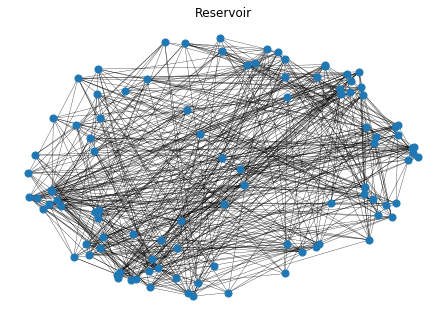

The reservoir has 100 nodes and 531 edges


In [5]:
########################
# Reservoir
########################

Network.W = np.zeros([Network.N,Network.N]) #adjacency matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p <0.025:
            Network.W[i,j] = 0.4            
            
        elif 0.025 <= p <0.05:
            Network.W[i,j] = -0.4
            

G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

In [6]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 1.0019890888527054
The maximum singular value (in module) is 2.025420168167204


We rescale the weights so as to get $|\lambda_\text{max}|\sim 0.22$. This small value guarantees a fast input/state forgetting.

In [7]:
alpha = 0.22/max(abs(scipy.linalg.eigvals(Network.W)))
Network.W = alpha*Network.W

In [8]:
print("The maximum eigenvalue (in module) is {}".format(max(abs(scipy.linalg.eigvals(Network.W)))))
_,s,_ = scipy.linalg.svd(Network.W)
print("The maximum singular value (in module) is {}".format(s[0]))

The maximum eigenvalue (in module) is 0.2200000000000015
The maximum singular value (in module) is 0.4447078735228503


Since $\sigma_{max}<1$, the existence of echo states is guaranteed.

### Training

Let us now perform the training. The update of the reservoir is going to be determined by

$$
x(n+1)=\tanh(W^\text{in}u(n+1)+Wx(n)+W^\text{back}y^\text{teach}(n)).
$$

Notice that, in this case, the matrices $W^\text{in}$ and $W^\text{back}$ are both non-null. 

The MSE is going to be computed component-wise. That is, since we are going to dismiss the first 50 time-steps,

$$
\text{MSE}_{\text{train},i} = \frac{1}{4000}\sum_{n=51}^{4050}\left(\tanh^{-1}\left(y^\text{teach}[i,n]\right)-\left(W^\text{out}x(n)\right)[i]\right)^2.
$$

Keep in mind that, after the dismissal, $y^\text{teach}$ is a matrix of size $20\times 4000$. Therefore, the $i$-th row gives the temporal evolution of the $i$-th channel. Similarly, $W^\text{out}$ is the matrix to be learnt, which is of size $20\times 100$. Therefore, the $i$-th component of the vector obtained from the product $\left(W^\text{out}x(n)\right)$ gives the output of the network corresponding to the $i$-th channel at time $n$. 

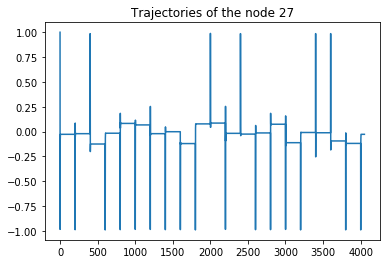

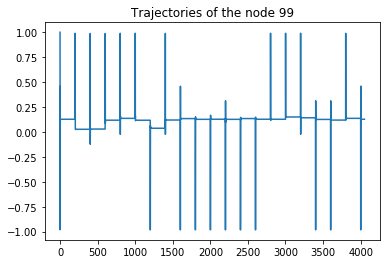

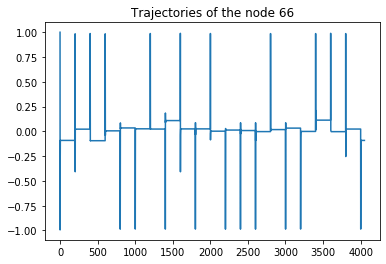

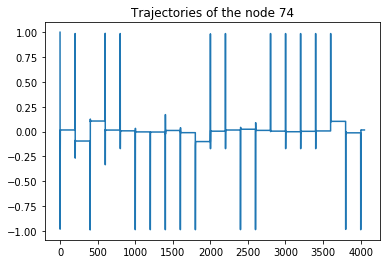

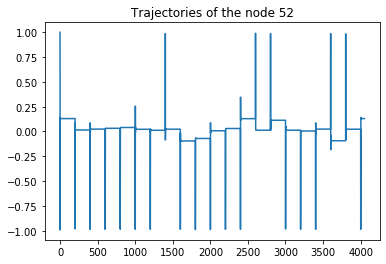

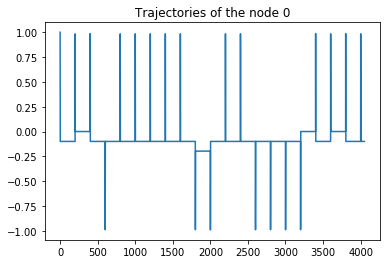

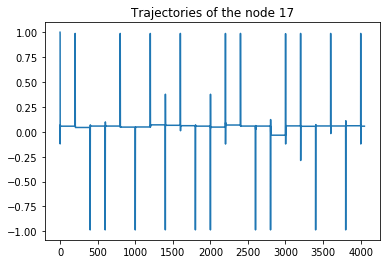

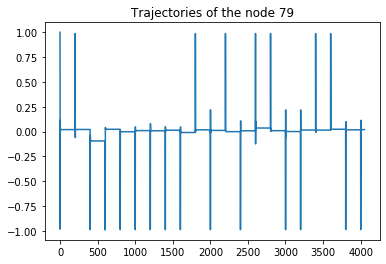

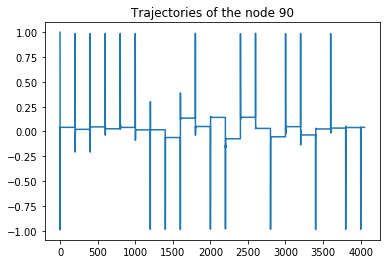

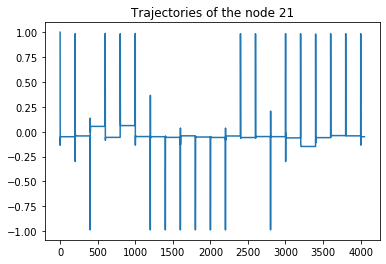

The training MSE for the 1-th dimension is 1.0233190789448458e-07
The training MSE for the 2-th dimension is 6.953790059472118e-07
The training MSE for the 3-th dimension is 7.81414037306394e-08
The training MSE for the 4-th dimension is 3.219582922209118e-07
The training MSE for the 5-th dimension is 4.121476876727642e-07
The training MSE for the 6-th dimension is 1.230106815202907e-07
The training MSE for the 7-th dimension is 1.9020819938575957e-07
The training MSE for the 8-th dimension is 2.235735755788631e-07
The training MSE for the 9-th dimension is 1.9182937069433563e-07
The training MSE for the 10-th dimension is 1.3296653174742674e-07
The training MSE for the 11-th dimension is 1.1520794424330016e-07
The training MSE for the 12-th dimension is 3.4184672398401933e-07
The training MSE for the 13-th dimension is 1.8202402212669844e-07
The training MSE for the 14-th dimension is 7.502281317840782e-08
The training MSE for the 15-th dimension is 4.5076060447630067e-07
The training

In [9]:
#After the plots, the training MSE for each component is printed
Network.train_network(plot=True)

We get a training MSE of the order of e-7 or e-8 for each component.

### 2.1.1 Testing on a sequence similar to the one used for training <a name="TestingSimilar" ></a>

For doing the test, we are going to create an input signal (with dimension 20) in the same way we created the training input. That is, one channel is going to spike every 200 time-steps. They are going to spike in order. Since we are now in the testing step, the updating of the reservoir is going to be carried out as follows

$$
x(n+1)=\tanh(W^\text{in}u_\text{test}(n+1)+Wx(n)+W^\text{back}y(n)),
$$

where $u_\text{test}$ is the testing input and $y$ is the output produced by the network. In addition, the output of the network will be computed as follows

$$
y(n+1)=f^\text{out}\left(W^\text{out}(u(n+1),x(n+1),y(n))\right) = \tanh\left(W^\text{out}x(n+1)\right).
$$

#### 4000 time-steps

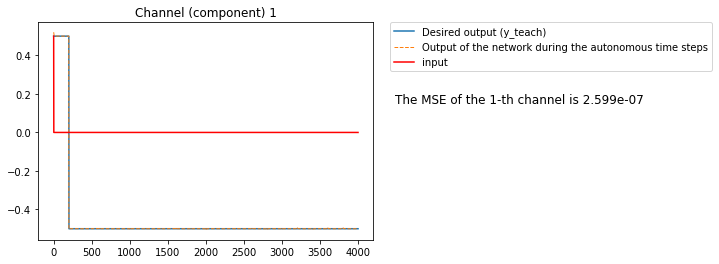

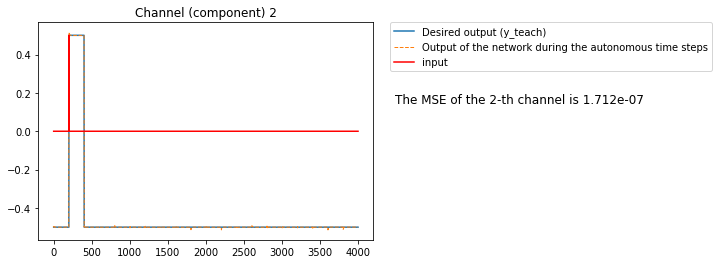

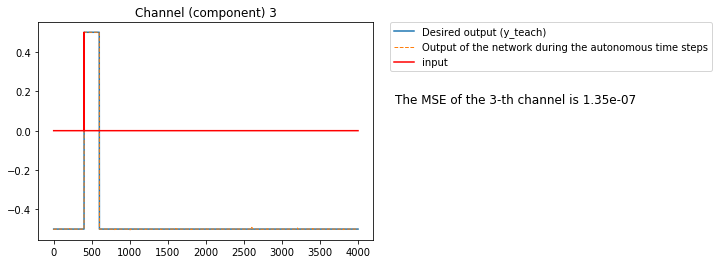

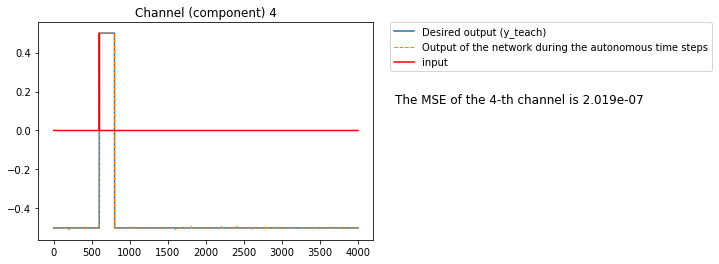

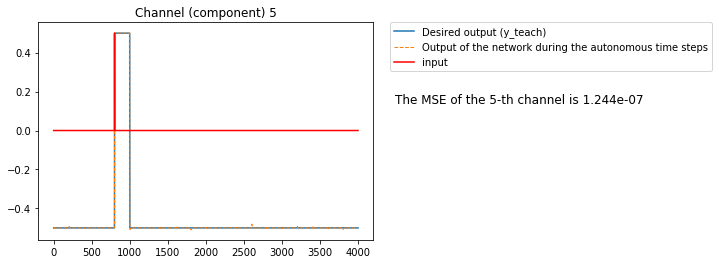

The test MSE for the 1-th dimension is 2.5988367504759437e-07
The test MSE for the 2-th dimension is 1.7123415555810023e-07
The test MSE for the 3-th dimension is 1.350255458133182e-07
The test MSE for the 4-th dimension is 2.0188083660465383e-07
The test MSE for the 5-th dimension is 1.2443263336083853e-07
The test MSE for the 6-th dimension is 8.77134866592168e-08
The test MSE for the 7-th dimension is 6.068980384539802e-08
The test MSE for the 8-th dimension is 4.2088291177186656e-08
The test MSE for the 9-th dimension is 2.8920033903502464e-08
The test MSE for the 10-th dimension is 1.991005615261122e-08
The test MSE for the 11-th dimension is 1.3674391260186784e-08
The test MSE for the 12-th dimension is 9.37168370277691e-09
The test MSE for the 13-th dimension is 6.400681554304185e-09
The test MSE for the 14-th dimension is 4.352272172901528e-09
The test MSE for the 15-th dimension is 2.9429408009300244e-09
The test MSE for the 16-th dimension is 1.9764297302975698e-09
The test M

In [10]:
#test time-steps
t_autonom = 4000
Network.test_network(t_autonom=t_autonom, plot=True)

#### 40000 time-steps

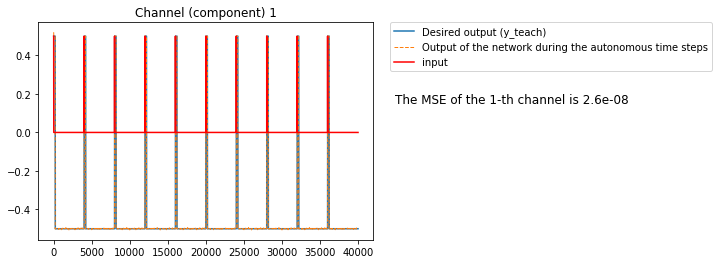

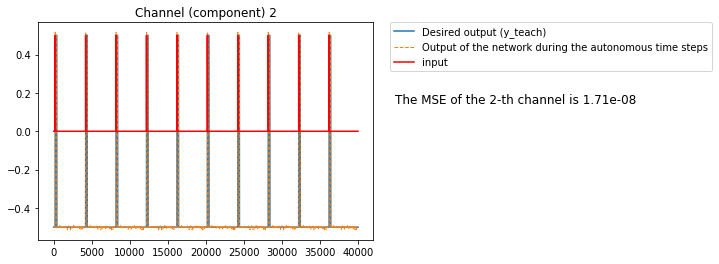

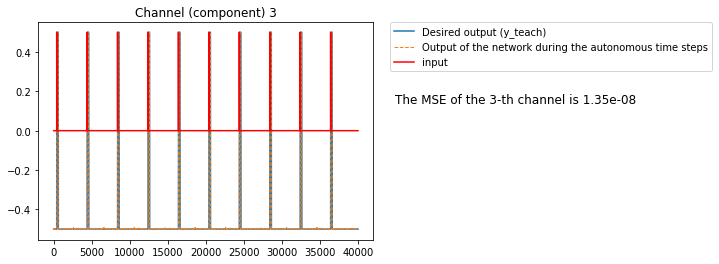

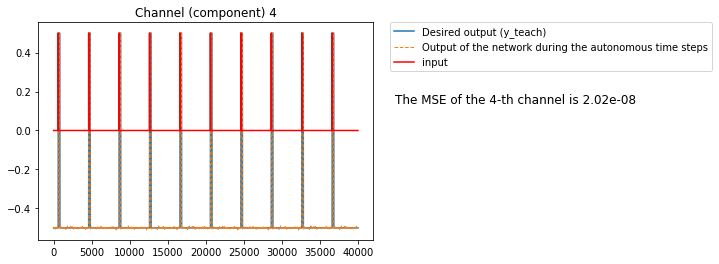

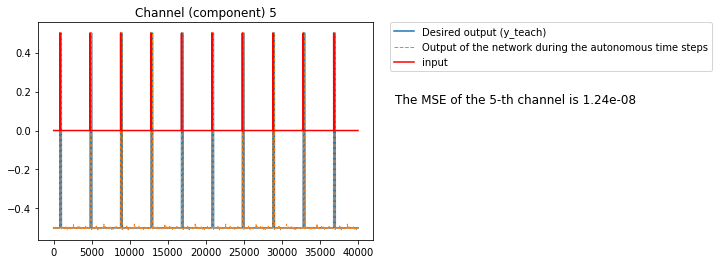

The test MSE for the 1-th dimension is 2.5988367504759436e-08
The test MSE for the 2-th dimension is 1.7123415555810024e-08
The test MSE for the 3-th dimension is 1.350255458133182e-08
The test MSE for the 4-th dimension is 2.0188083660465383e-08
The test MSE for the 5-th dimension is 1.2443263336083852e-08
The test MSE for the 6-th dimension is 8.77134866592168e-09
The test MSE for the 7-th dimension is 6.068980384539803e-09
The test MSE for the 8-th dimension is 4.208829117718666e-09
The test MSE for the 9-th dimension is 2.8920033903502464e-09
The test MSE for the 10-th dimension is 1.991005615261122e-09
The test MSE for the 11-th dimension is 1.3674391260186784e-09
The test MSE for the 12-th dimension is 9.371683702776911e-10
The test MSE for the 13-th dimension is 6.400681554304185e-10
The test MSE for the 14-th dimension is 4.352272172901528e-10
The test MSE for the 15-th dimension is 2.9429408009300245e-10
The test MSE for the 16-th dimension is 1.9764297302975698e-10
The test M

In [11]:
#test time-steps
t_autonom = 40000
Network.test_network(t_autonom=t_autonom, plot=True)

Notice that, in both testings, the results are very accurate. It is worth noting the decreasing tendency of the error along channels. The reason is the fact that the spiking occurs every 200 time steps in a sorted way: the $i$-th spiking occurs in the $i$-th channel, for $i\in\{1,2,...,20\}$. Therefore, when a larger channel spikes, the network has already been trained in all the previous smaller channels. For instance, when the spikes occurs at channel 17, the network has already been trained for 16 spikes that occurred in the 16 previous channels. 

### 2.1.2 Testing on a sequence consisting of random spikes <a name="TestingDifferent" ></a>

Let us try to test the trained network with another type of input. The input signal is going to be defined in such a way that, at any time step $n$, at most one of the input channels spikes with probability 0.02. Notice that the channels do not have to spike following any order. The rest of the features are going to be the same. 

We are going to use the already trained network so as to test it performance with this other type of input.

#### 500 time-steps

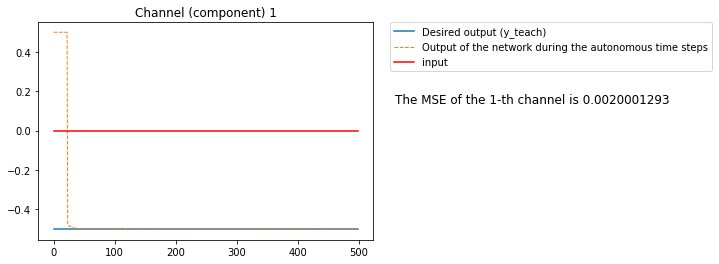

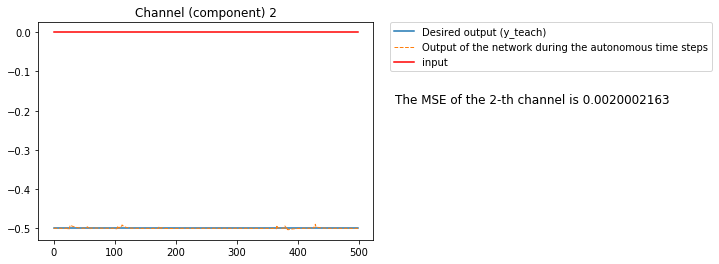

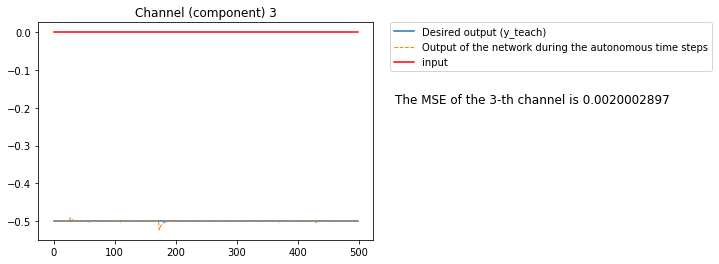

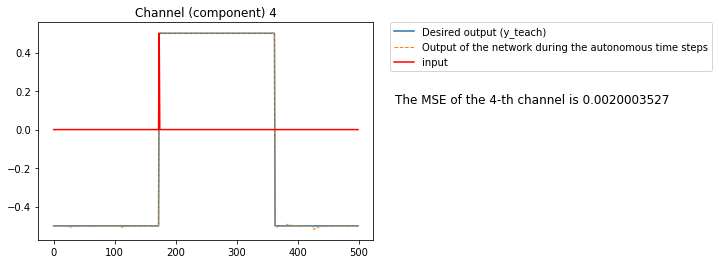

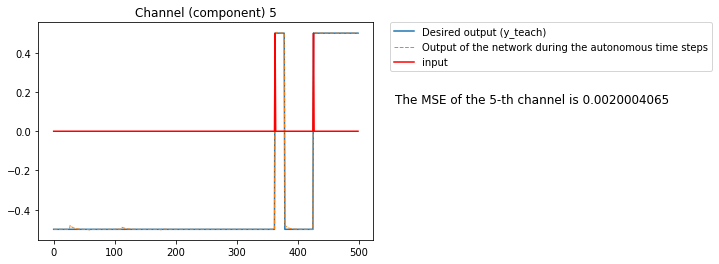

The test MSE for the 1-th dimension is 0.002000129286858883
The test MSE for the 2-th dimension is 0.002000216314343494
The test MSE for the 3-th dimension is 0.0020002896869735403
The test MSE for the 4-th dimension is 0.002000352665354412
The test MSE for the 5-th dimension is 0.0020004065165332625
The test MSE for the 6-th dimension is 0.0020004524948080715
The test MSE for the 7-th dimension is 0.0020004917430712435
The test MSE for the 8-th dimension is 0.002000525226060464
The test MSE for the 9-th dimension is 0.0020005537781075237
The test MSE for the 10-th dimension is 0.0020005781171860137
The test MSE for the 11-th dimension is 0.002000598859613734
The test MSE for the 12-th dimension is 0.0020006165335582585
The test MSE for the 13-th dimension is 0.0020006315910680093
The test MSE for the 14-th dimension is 0.0020006444185967525
The test MSE for the 15-th dimension is 0.0020006553462013996
The test MSE for the 16-th dimension is 0.002000664655539461
The test MSE for the 17

In [13]:
#test time-steps
t_autonom = 500
Network.test_network(t_autonom=t_autonom, spikes_random=True, plot=True)

#### 4000 time-steps

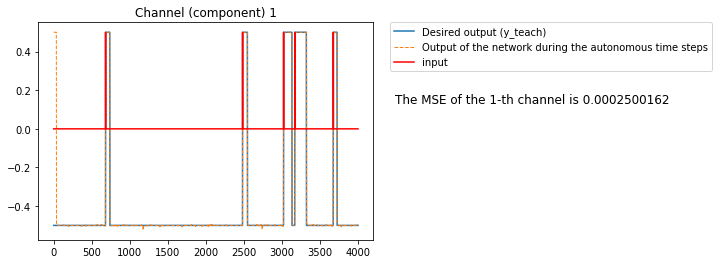

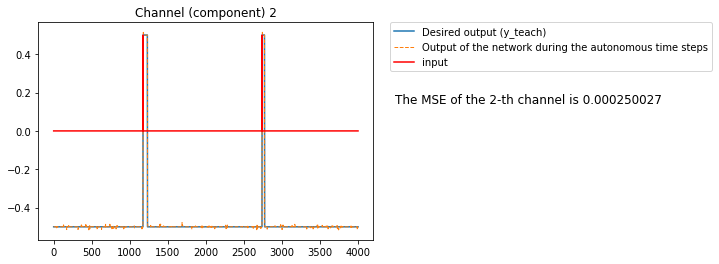

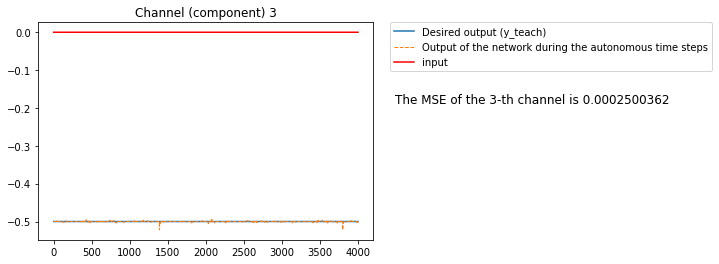

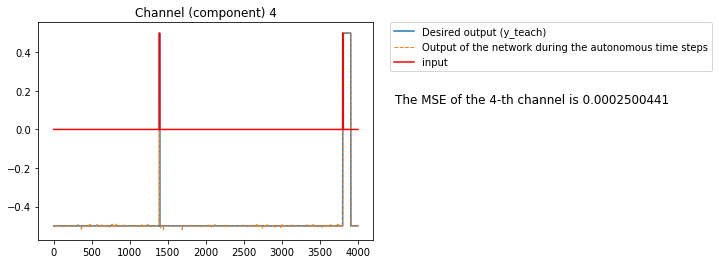

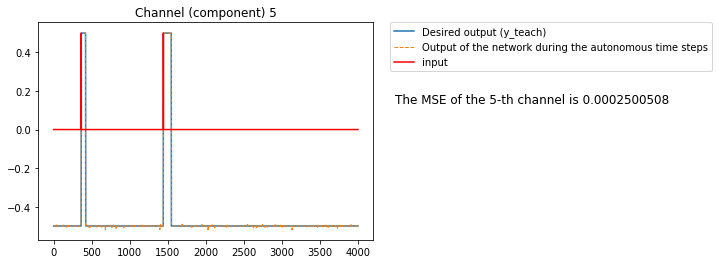

The test MSE for the 1-th dimension is 0.00025001616085736035
The test MSE for the 2-th dimension is 0.00025002703929293674
The test MSE for the 3-th dimension is 0.00025003621087169253
The test MSE for the 4-th dimension is 0.0002500440831693015
The test MSE for the 5-th dimension is 0.0002500508145666578
The test MSE for the 6-th dimension is 0.00025005656185100893
The test MSE for the 7-th dimension is 0.00025006146788390544
The test MSE for the 8-th dimension is 0.000250065653257558
The test MSE for the 9-th dimension is 0.00025006922226344046
The test MSE for the 10-th dimension is 0.0002500722646482517
The test MSE for the 11-th dimension is 0.00025007485745171676
The test MSE for the 12-th dimension is 0.0002500770666947823
The test MSE for the 13-th dimension is 0.00025007894888350116
The test MSE for the 14-th dimension is 0.00025008055232459406
The test MSE for the 15-th dimension is 0.00025008191827517495
The test MSE for the 16-th dimension is 0.0002500830819424326
The test

In [14]:
#test time-steps
t_autonom = 4000
Network.test_network(t_autonom=t_autonom, spikes_random=True, plot=True)

Notice that in both testing cases, the prediction is the desired one. The reason why it works is because we have used a network with few memory. That is, the dynamics is mostly learnt from the input and the previous output. 

In the next section, we will try to learn the same dynamics but we are going to directly train the network using this type of random input. 

## 2.2 Unordered and random spiking <a name="UnorderedSpiking" ></a>

The problem we are now going to tackle is going to be the same as above but, at this time, the spiking is going to be slightly different. The input signal is going to be defined in such a way that, at any time step $n$, at most one of the input channels spikes with probability 0.02. Notice that the channels do not have to spike following any order. The rest of the features are going to be the same.

In the cells that are right above, we have learnt this type of dynamics using the former trained network. Recall that it was trained by means of a particular input, which consisted on an ordered and cyclic spiking every 200 time steps. However, in this section we are going to train the network using an input that follows the same dynamics we aim to learn.

In [15]:
#TRAINING TIME
Network.T = 4000
Network.n_min = 50

### Training

The training is done in the same way as in [Section 2.1](#OrderedSpiking).

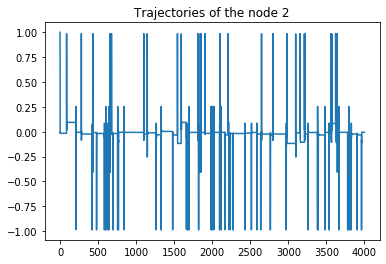

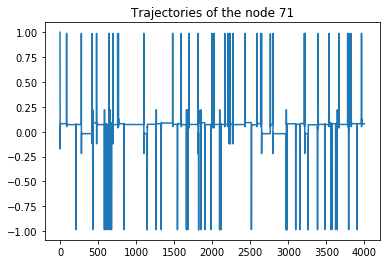

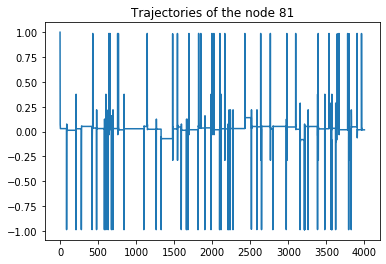

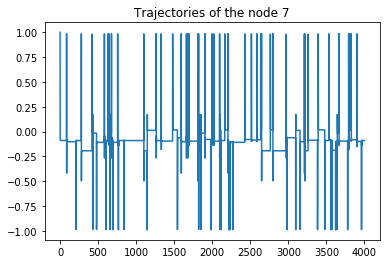

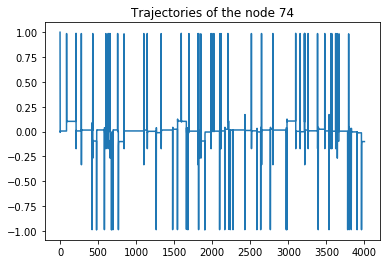

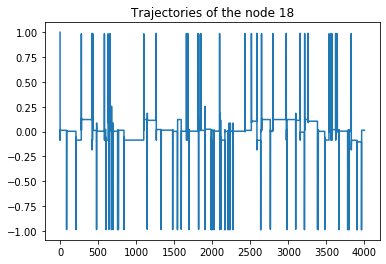

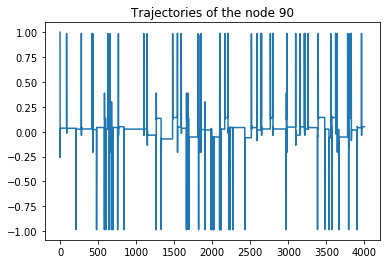

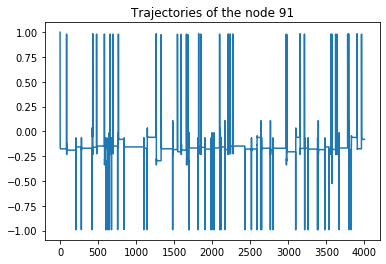

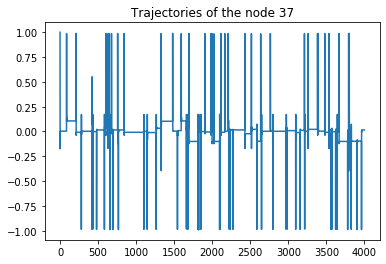

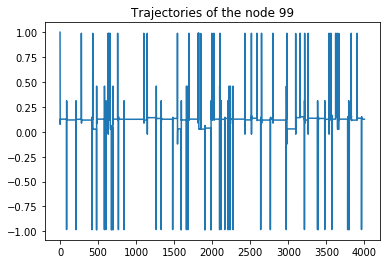

The training MSE for the 1-th dimension is 1.2041838468186253e-06
The training MSE for the 2-th dimension is 2.9555856863730745e-06
The training MSE for the 3-th dimension is 5.503743346535776e-07
The training MSE for the 4-th dimension is 2.211133286737136e-06
The training MSE for the 5-th dimension is 1.5372061463239288e-06
The training MSE for the 6-th dimension is 8.705838473782702e-07
The training MSE for the 7-th dimension is 1.0701657787033536e-06
The training MSE for the 8-th dimension is 9.037501100361072e-07
The training MSE for the 9-th dimension is 1.614140165876851e-06
The training MSE for the 10-th dimension is 1.107922113957659e-06
The training MSE for the 11-th dimension is 5.522750562309254e-07
The training MSE for the 12-th dimension is 1.5785873537554178e-06
The training MSE for the 13-th dimension is 1.7205844048635919e-06
The training MSE for the 14-th dimension is 4.877229668458437e-07
The training MSE for the 15-th dimension is 2.2017163481464012e-06
The training

In [16]:
#After the plots, the training MSE for each component is printed
Network.train_network(plot=True, spikes_random=True)

The training MSE are of the order e-6 or e-7 for each component.

### Testing

The testing is performed in the same way as in [Section 2.1](#OrderedSpiking).

#### T=500 time steps

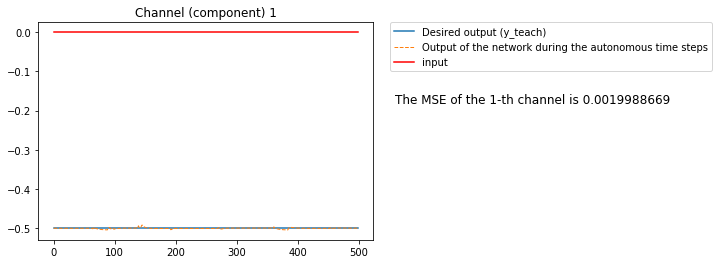

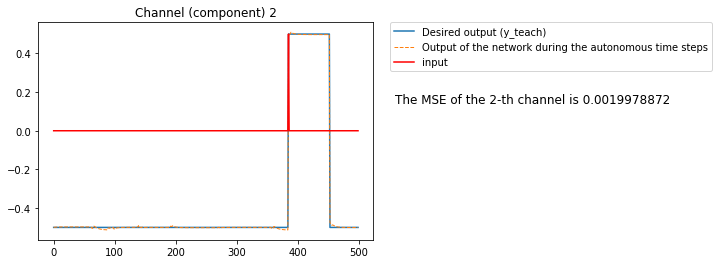

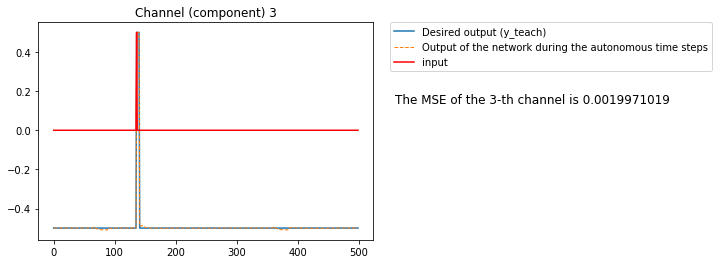

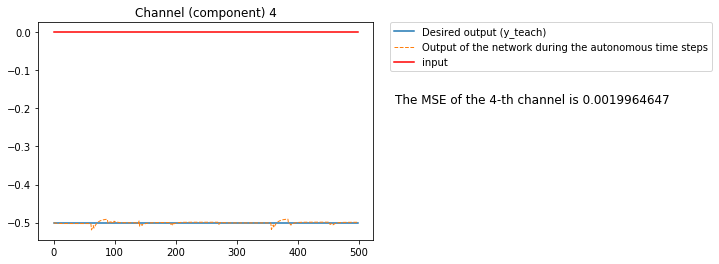

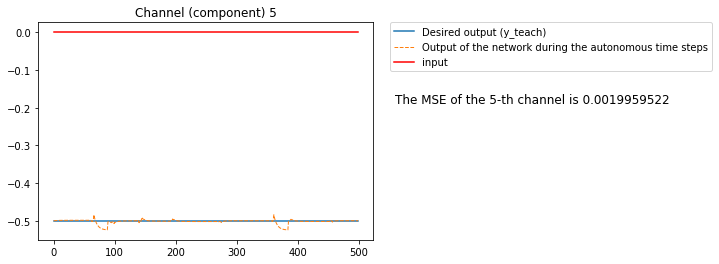

The test MSE for the 1-th dimension is 0.00199886691449469
The test MSE for the 2-th dimension is 0.0019978872483481
The test MSE for the 3-th dimension is 0.0019971018862864733
The test MSE for the 4-th dimension is 0.0019964646666917564
The test MSE for the 5-th dimension is 0.00199595223240831
The test MSE for the 6-th dimension is 0.0019955417394987964
The test MSE for the 7-th dimension is 0.0019952123716845687
The test MSE for the 8-th dimension is 0.0019949476245397614
The test MSE for the 9-th dimension is 0.001994734538090162
The test MSE for the 10-th dimension is 0.0019945627914022494
The test MSE for the 11-th dimension is 0.0019944241672139773
The test MSE for the 12-th dimension is 0.001994312117786566
The test MSE for the 13-th dimension is 0.001994221417928672
The test MSE for the 14-th dimension is 0.0019941478922780274
The test MSE for the 15-th dimension is 0.001994088200327724
The test MSE for the 16-th dimension is 0.001994039666261717
The test MSE for the 17-th di

In [17]:
#test time-steps
t_autonom = 500
Network.test_network(t_autonom=t_autonom, spikes_random=True, plot=True)

#### T=4000 time steps

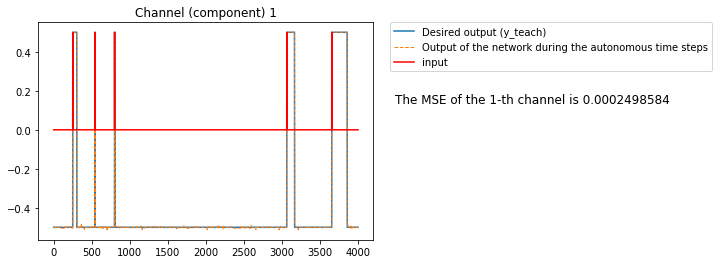

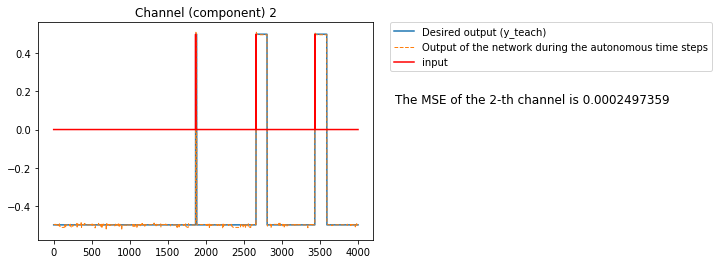

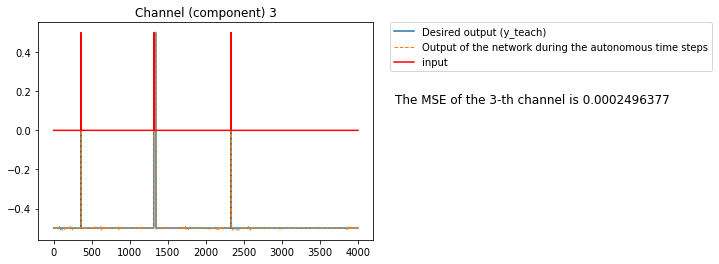

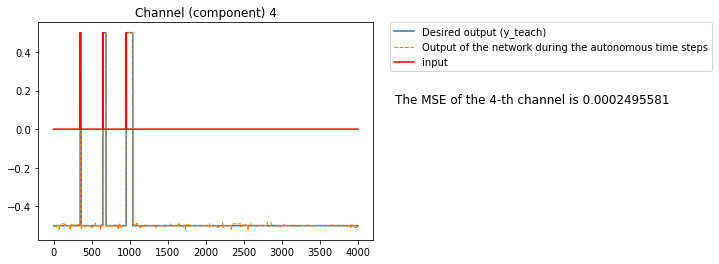

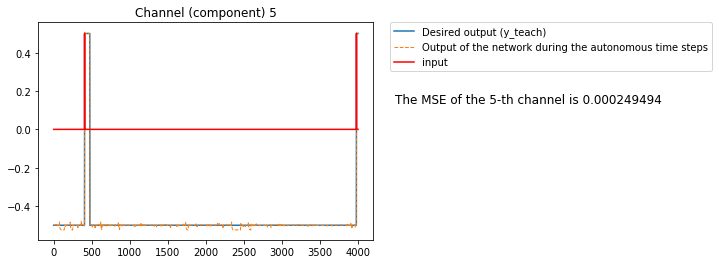

The test MSE for the 1-th dimension is 0.0002498583643118362
The test MSE for the 2-th dimension is 0.0002497359060435125
The test MSE for the 3-th dimension is 0.00024963773578580916
The test MSE for the 4-th dimension is 0.00024955808333646955
The test MSE for the 5-th dimension is 0.00024949402905103876
The test MSE for the 6-th dimension is 0.00024944271743734955
The test MSE for the 7-th dimension is 0.0002494015464605711
The test MSE for the 8-th dimension is 0.0002493684530674702
The test MSE for the 9-th dimension is 0.00024934181726127025
The test MSE for the 10-th dimension is 0.00024932034892528117
The test MSE for the 11-th dimension is 0.00024930302090174717
The test MSE for the 12-th dimension is 0.00024928901472332074
The test MSE for the 13-th dimension is 0.000249277677241084
The test MSE for the 14-th dimension is 0.00024926848653475343
The test MSE for the 15-th dimension is 0.0002492610250409655
The test MSE for the 16-th dimension is 0.00024925495828271465
The test

In [18]:
#test time-steps
t_autonom = 4000
Network.test_network(t_autonom=t_autonom, spikes_random=True, plot=True)

The predictions on the test are very accurate. Therefore, the dynamics have been learnt using an input that follows the same dynamics. Thus, in order to learn we do not need any particular input but any input that follows the dynamics we want to learn.  